## Local Authority Mapping
- ID 88: Wakefield

In [3]:
import pandas as pd
import json
import urllib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
# Set region ID; all possible region IDs are shown in the list in the description above
la_id = 88

start_date = "01012014"
end_date = "31122020"

countsites_path = "../01_LocalAuthorities/la_countsite_dict.json"

In [5]:
df_aadt = pd.read_csv(f"./Data/AADT/dft_aadf_local_authority_id_{la_id}.csv")
df_ghg = pd.read_csv("./Data/UK_LA_GHG_EMISSIONS.csv")

la_name = df_aadt.sample().iloc[0]["local_authority_name"]
la_code = df_ghg[df_ghg["Local Authority"] == la_name].iloc[0]["Local Authority Code"]

In [6]:
df_relevant_aadt = df_aadt[(df_aadt["road_name"].str.startswith("A")) & (df_aadt["estimation_method"] == "Counted")]

df_aadt_aroads_one_digit = df_relevant_aadt[df_relevant_aadt["road_name"].str.contains("^A\d$")]
df_aadt_aroads_two_digit = df_relevant_aadt[df_relevant_aadt["road_name"].str.contains("^A\d{2}$")]
df_aadt_aroads_three_digit = df_relevant_aadt[df_relevant_aadt["road_name"].str.contains("^A\d{3}$")]


In [7]:
df_aadt_aroads_three_digit["road_name"].unique()

array(['A638', 'A162', 'A639', 'A636', 'A645', 'A650', 'A642', 'A655',
       'A637', 'A628', 'A656'], dtype=object)

{'whiskers': [<matplotlib.lines.Line2D at 0x21459f766d0>,
 'caps': [<matplotlib.lines.Line2D at 0x21459f76a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x21459f76400>,
 'medians': [<matplotlib.lines.Line2D at 0x21459f7e280>,
 'fliers': [<matplotlib.lines.Line2D at 0x21459f7e2b0>,
 'means': []}

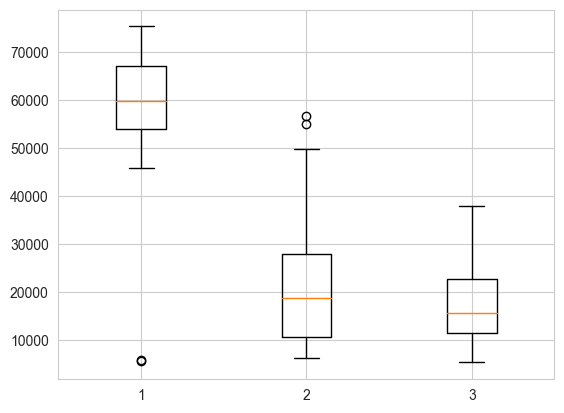

In [8]:
data_one_digit = list(df_aadt_aroads_one_digit["all_motor_vehicles"])
data_two_digit = list(df_aadt_aroads_two_digit["all_motor_vehicles"])
data_three_digit = list(df_aadt_aroads_three_digit["all_motor_vehicles"])

plt.boxplot([data_one_digit, data_two_digit, data_three_digit])

In [9]:
import matplotlib.pyplot as plt

df_mean_aadt = df_relevant_aadt.groupby(["year"])[["two_wheeled_motor_vehicles", "buses_and_coaches", "lgvs", "all_hgvs", "cars_and_taxis", "all_motor_vehicles"]].max()
df_mean_aadt

,two_wheeled_motor_vehicles,buses_and_coaches,lgvs,all_hgvs,cars_and_taxis,all_motor_vehicles
year,,,,,,
2000,349,447,6155,10565,39262,56537
2001,326,568,5777,10499,39403,55768
2002,571,1192,5879,10946,47682,56736
2003,294,385,6516,10263,40838,58289
2004,282,641,6728,11813,36883,54395
2005,358,607,6573,11026,35774,53883
2006,316,491,8804,11687,47672,68584
2007,242,404,7739,10415,42816,61498
2008,299,515,7503,11554,44409,63906


In [10]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_aadt, title="Profiling Report")

In [11]:
boolean_mask1 = (df_ghg["Local Authority Code"] == la_code)
boolean_mask2 = (df_ghg["LA GHG Sector"] == "Transport")
boolean_mask3 = (df_ghg["LA GHG Sub-sector"] == "Road Transport (A roads)")

df_relevant_ghg = df_ghg[boolean_mask1 & boolean_mask2 & boolean_mask3]

In [12]:
df_total_ghg = df_relevant_ghg.groupby(["Calendar Year"])[["Territorial emissions (kt CO2e)", "CO2 emissions within the scope of influence of LAs (kt CO2e)"]].sum()

C:\Users\elias\AppData\Local\Temp\ipykernel_11116\4179262595.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


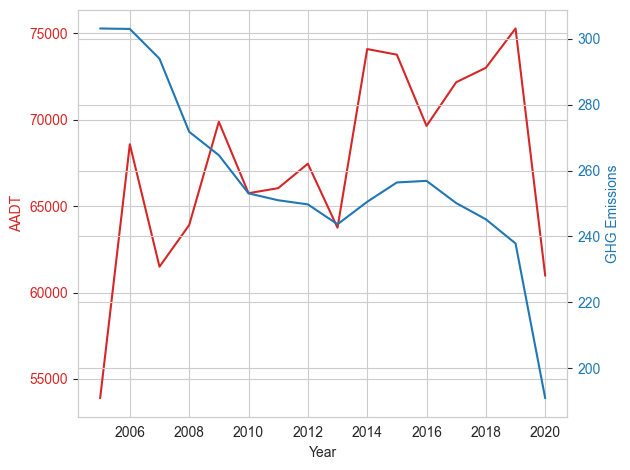

In [13]:
from scipy.ndimage.filters import gaussian_filter1d

df_aadt_ghg = pd.merge(df_total_ghg, df_mean_aadt, left_index=True, right_index=True)
years = list(df_aadt_ghg.index)
aadt = list(df_aadt_ghg["all_motor_vehicles"])
ghg = list(df_aadt_ghg["Territorial emissions (kt CO2e)"])

aadt_smooth = gaussian_filter1d(aadt, sigma=2)
ghg_smooth = gaussian_filter1d(ghg, sigma=2)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('AADT', color=color)
ax1.plot(years, aadt, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('GHG Emissions', color=color)  # we already handled the x-label with ax1
ax2.plot(years, ghg, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [14]:
df_total_ghg

,Territorial emissions (kt CO2e),CO2 emissions within the scope of influence of LAs (kt CO2e)
Calendar Year,,
2005,303.159238,297.788130
2006,303.022782,297.962195
2007,293.980515,289.229641
2008,271.783861,267.898812
2009,264.678538,260.870842
2010,253.086790,249.554079
2011,250.984700,247.219518
2012,249.729801,246.096040
2013,243.697198,240.087500


In [31]:
boolean_mask1 = (df_ghg["LA GHG Sector"] == "Transport")
#boolean_mask2 = (df_ghg["LA GHG Sub-sector"] == "Road Transport (A roads)")
boolean_mask2 = (df_ghg["LA GHG Sub-sector"] == "Road Transport (Motorways)")
boolean_mask3 = (df_ghg["Calendar Year"] == 2018)
boolean_mask4 = (df_ghg["Greenhouse gas"] == "CO2")

df_relevant_ghg = df_ghg[boolean_mask1 & boolean_mask2 & boolean_mask3 & boolean_mask4]

df_ghg_all_las = df_relevant_ghg

df_ghg_all_las

,Country,Country Code,Region,Region Code,Second Tier Authority,Local Authority,Local Authority Code,Calendar Year,LA GHG Sector,LA GHG Sub-sector,Greenhouse gas,Territorial emissions (kt CO2e),CO2 emissions within the scope of influence of LAs (kt CO2e),Mid-year Population (thousands),Area (km2)
3488,England,E92000001,East Midlands,E12000004,Derbyshire,Bolsover,E07000033,2018,Transport,Road Transport (Motorways),CO2,192.748072,0.0,79.530,160.3347
4740,England,E92000001,East Midlands,E12000004,Derbyshire,Chesterfield,E07000034,2018,Transport,Road Transport (Motorways),CO2,24.854532,0.0,104.628,66.0352
7217,England,E92000001,East Midlands,E12000004,Derbyshire,Erewash,E07000036,2018,Transport,Road Transport (Motorways),CO2,89.720577,0.0,115.490,109.6301
9807,England,E92000001,East Midlands,E12000004,Derbyshire,North East Derbyshire,E07000038,2018,Transport,Road Transport (Motorways),CO2,68.233790,0.0,101.125,275.6234
13508,England,E92000001,East Midlands,E12000004,Leicestershire,Blaby,E07000129,2018,Transport,Road Transport (Motorways),CO2,201.352444,0.0,100.421,130.4686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457043,Wales,W92000004,Wales,W92000004,Wales,Neath Port Talbot,W06000012,2018,Transport,Road Transport (Motorways),CO2,106.987265,0.0,142.906,451.8754
458299,Wales,W92000004,Wales,W92000004,Wales,Newport,W06000022,2018,Transport,Road Transport (Motorways),CO2,193.943437,0.0,153.302,217.4554
462145,Wales,W92000004,Wales,W92000004,Wales,Rhondda Cynon Taf,W06000016,2018,Transport,Road Transport (Motorways),CO2,61.650713,0.0,240.131,424.1502
463453,Wales,W92000004,Wales,W92000004,Wales,Swansea,W06000011,2018,Transport,Road Transport (Motorways),CO2,75.205911,0.0,246.466,420.8260


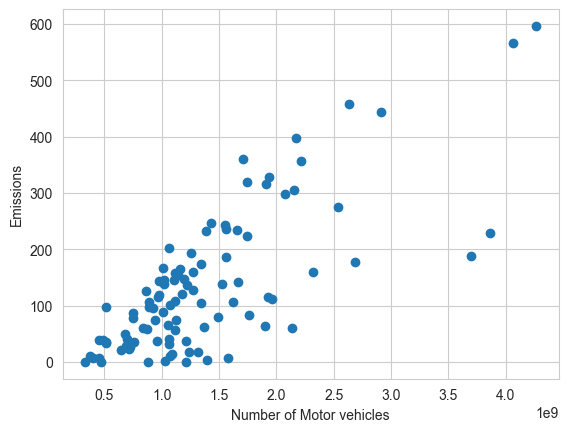

In [32]:
df_traffic = pd.read_csv("./Data/local_authority_traffic.csv")

df_merged = df_ghg_all_las.merge(df_traffic, left_on="Local Authority Code", right_on="ONS_code")

boolean_mask1 = (df_merged["year"] == 2018)

df_merged = df_merged[boolean_mask1]

plt.scatter(list(df_merged["all_motor_vehicles"]), list(df_merged["Territorial emissions (kt CO2e)"]))
plt.xlabel("Number of Motor vehicles")
plt.ylabel("Emissions")
plt.show()

,Country,Country Code,Region,Region Code,Second Tier Authority,Local Authority,Local Authority Code,Calendar Year,LA GHG Sector,LA GHG Sub-sector,...,Mid-year Population (thousands),Area (km2),Local_authority_id,name,ONS_code,year,link_length_km,link_length_miles,cars_and_taxis,all_motor_vehicles
25,England,E92000001,East Midlands,E12000004,Derby,Derby,E06000015,2005,Agriculture,Agriculture Electricity,...,236.470,78.0311,119,Derby,E06000015,2018,771.8626,479.61,931023666.0,1.115612e+09
55,England,E92000001,East Midlands,E12000004,Derby,Derby,E06000015,2005,Agriculture,Agriculture Electricity,...,236.470,78.0311,119,Derby,E06000015,2018,771.8626,479.61,931023666.0,1.115612e+09
85,England,E92000001,East Midlands,E12000004,Derby,Derby,E06000015,2005,Agriculture,Agriculture Electricity,...,236.470,78.0311,119,Derby,E06000015,2018,771.8626,479.61,931023666.0,1.115612e+09
115,England,E92000001,East Midlands,E12000004,Derby,Derby,E06000015,2005,Agriculture,Agriculture Gas,...,236.470,78.0311,119,Derby,E06000015,2018,771.8626,479.61,931023666.0,1.115612e+09
145,England,E92000001,East Midlands,E12000004,Derby,Derby,E06000015,2005,Agriculture,Agriculture Gas,...,236.470,78.0311,119,Derby,E06000015,2018,771.8626,479.61,931023666.0,1.115612e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6609833,Wales,W92000004,Wales,W92000004,Wales,Wrexham,W06000006,2020,Transport,Transport 'Other',...,136.055,503.7739,26,Wrexham,W06000006,2018,1212.5868,753.47,529398699.4,6.868939e+08
6609863,Wales,W92000004,Wales,W92000004,Wales,Wrexham,W06000006,2020,Waste management,Landfill,...,136.055,503.7739,26,Wrexham,W06000006,2018,1212.5868,753.47,529398699.4,6.868939e+08
6609893,Wales,W92000004,Wales,W92000004,Wales,Wrexham,W06000006,2020,Waste management,Waste management 'Other',...,136.055,503.7739,26,Wrexham,W06000006,2018,1212.5868,753.47,529398699.4,6.868939e+08
6609923,Wales,W92000004,Wales,W92000004,Wales,Wrexham,W06000006,2020,Waste management,Waste management 'Other',...,136.055,503.7739,26,Wrexham,W06000006,2018,1212.5868,753.47,529398699.4,6.868939e+08
